In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import datetime

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, RNN, LSTMCell


import warnings
warnings.filterwarnings("ignore")


2025-09-30 09:37:57.485088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759225077.766054      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759225077.842413      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
plt.rcParams["figure.figsize"] =  (10,4)

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

In [9]:
url = "/kaggle/input/stock-market-data/stock_market_data/nasdaq/csv/AAL.csv"
_df = pd.read_csv(url, sep=",")
len(_df)

4333

In [10]:
df =  _df.copy()
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


# Data cleanup

In [11]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940


In [12]:
df.tail()

,Date,Low,Open,Volume,High,Close,Adjusted Close
4328,06-12-2022,14.00,14.14,20781500,14.34,14.330,14.330
4329,07-12-2022,13.53,14.24,28161400,14.24,13.550,13.550
4330,08-12-2022,13.38,13.65,25300900,13.80,13.600,13.600
4331,09-12-2022,13.42,13.52,18489800,13.66,13.530,13.530
4332,12-12-2022,13.45,13.49,8048550,13.93,13.915,13.915


Stars 2005 ends 0n 2022. collected at work day (sat and sun wasn't inclued)

In [13]:
df.shape # 7 columns and 4333 rows

(4333, 7)

In [14]:
df.isna().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [15]:
df.dtypes

Date               object
Low               float64
Open              float64
Volume              int64
High              float64
Close             float64
Adjusted Close    float64
dtype: object

In [16]:
# Convert Date into datetime data type
df["Date"] = pd.to_datetime(df["Date"])

In [17]:
df.dtypes

Date              datetime64[ns]
Low                      float64
Open                     float64
Volume                     int64
High                     float64
Close                    float64
Adjusted Close           float64
dtype: object

# Data Resampling
Check if data is sampled every day is approriate for modeling and if data sampled every day is too noisy to build performant predictive model

In [18]:
days_per_month = df.groupby(df["Date"].dt.to_period("M"))["Date"].nunique()

days_per_month = pd.DataFrame(days_per_month)
days_per_month.head(20)

,Date
Date,
2005-09,4
2005-10,21
2005-11,21
2005-12,21
2006-01,20
2006-02,19
2006-03,23
2006-04,19
2006-05,22


In [19]:
# year 2005 have noticeble less days the the rest. Drop 2005
df = df[df["Date"].dt.year != 2005]

df.reset_index(inplace = True, drop = True)

df.head(20)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242
5,2006-01-10,37.400002,38.610001,191300,38.709999,37.799999,35.635628
6,2006-01-11,34.650002,37.799999,974300,37.799999,34.799999,32.807415
7,2006-01-12,32.959999,33.000000,2008900,35.349998,34.990002,32.986526
8,2006-01-13,33.310001,35.000000,734200,35.419998,34.049999,32.100342
9,2006-01-17,29.620001,33.549999,2351200,33.549999,30.000000,28.282244


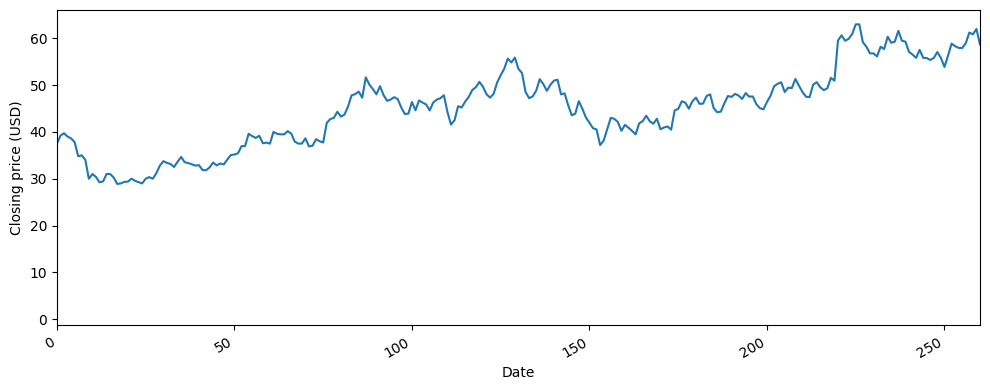

In [20]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(df["Close"])
ax.set_xlabel("Date")
ax.set_ylabel("Closing price (USD)")

ax.set_xlim(0, 260)

fig.autofmt_xdate()
plt.tight_layout()

**Figure**: close price sampled every day for one year. 

Data wrangling done. Save this clean up dataset as a new CSV file.

In [21]:
df.to_csv("../clean_AAL.csv", header=True, index=False)

# Feature Engineering
Start to read the cleanup version and working on feature engineering

In [22]:
df = pd.read_csv("../clean_AAL.csv")
df.head(20)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,2006-01-03,36.849998,37.200001,1013200,38.279999,37.450001,35.305672
1,2006-01-04,37.700001,37.700001,1928400,40.599998,39.200001,36.955467
2,2006-01-05,38.910000,39.180000,317900,39.709999,39.709999,37.436268
3,2006-01-06,38.139999,39.709999,349200,39.709999,39.000000,36.766914
4,2006-01-09,38.500000,38.799999,220800,38.880001,38.610001,36.399242
5,2006-01-10,37.400002,38.610001,191300,38.709999,37.799999,35.635628
6,2006-01-11,34.650002,37.799999,974300,37.799999,34.799999,32.807415
7,2006-01-12,32.959999,33.000000,2008900,35.349998,34.990002,32.986526
8,2006-01-13,33.310001,35.000000,734200,35.419998,34.049999,32.100342
9,2006-01-17,29.620001,33.549999,2351200,33.549999,30.000000,28.282244


1. Feature Selection
   To display the basic statistics for each column. This is useful for detecting if there are variables that do not vary and if so such variables should be removed. The variable is constant overtime is not predictive of the target.

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Low,4266.0,2.488723e+01,1.580789e+01,1.450000,1.053500e+01,2.133500e+01,3.914000e+01,6.200000e+01
Open,4266.0,2.538824e+01,1.600633e+01,1.810000,1.082250e+01,2.189000e+01,3.974500e+01,6.270000e+01
Volume,4266.0,1.458939e+07,2.207456e+07,191300.000000,4.749500e+06,7.557550e+06,1.352832e+07,4.286171e+08
High,4266.0,2.585412e+01,1.619366e+01,2.030000,1.111250e+01,2.224000e+01,4.029750e+01,6.327000e+01
Close,4266.0,2.535673e+01,1.600430e+01,1.760000,1.079250e+01,2.181500e+01,3.970500e+01,6.295000e+01
Adjusted Close,4266.0,2.439955e+01,1.533443e+01,1.659225,1.024113e+01,2.143500e+01,3.797598e+01,5.934557e+01


## Identify the seasonal period
* Some months or time of the years show recurring patterns. Example Sep often performs poorly and other months may do better.
* Why its matters: its based on historical event (looking at past years). Not sure about the future but as a guide some traders use. They may decide: buy during strong months or sell during weak month also when to buy dips to catch the lower prices.


In [24]:
# check for patterns: plot mean close per month and close per year
df["Date"] = pd.to_datetime(df["Date"])

# extract month and year from date column
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year

monthly_mean = df.groupby(["Month"])["Close"].mean().reset_index()

yearly_mean = df.groupby(["Year"])["Close"].mean().reset_index()


In [25]:
monthly_mean

,Month,Close
0,1,27.501545
1,2,27.312301
2,3,26.263324
3,4,25.501880
4,5,25.268106
5,6,24.701071
6,7,24.789972
7,8,23.683342
8,9,23.654870
9,10,24.397701


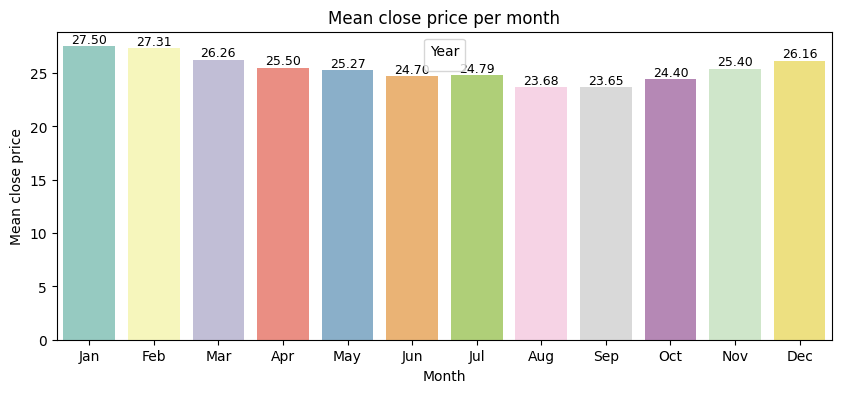

In [26]:
# plot the mean close price per month
ax = sns.barplot(data=monthly_mean, x="Month", y="Close", palette="Set3")

plt.title("Mean close price per month")
plt.xlabel("Month")
plt.ylabel("Mean close price")

plt.xticks(range(0,12), labels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.legend(title="Year")

for bar in ax.containers:
    ax.bar_label(bar, fontsize=9, fmt="%.2f")
plt.show()


**Figure**: Mean close price don't change much for all months

In [27]:
yearly_mean

,Year,Close
0,2006,44.322390
1,2007,35.671952
2,2008,7.742134
3,2009,3.829643
4,2010,8.636667
5,2011,7.459841
6,2012,10.496160
7,2013,18.187936
8,2014,38.923651
9,2015,45.122103


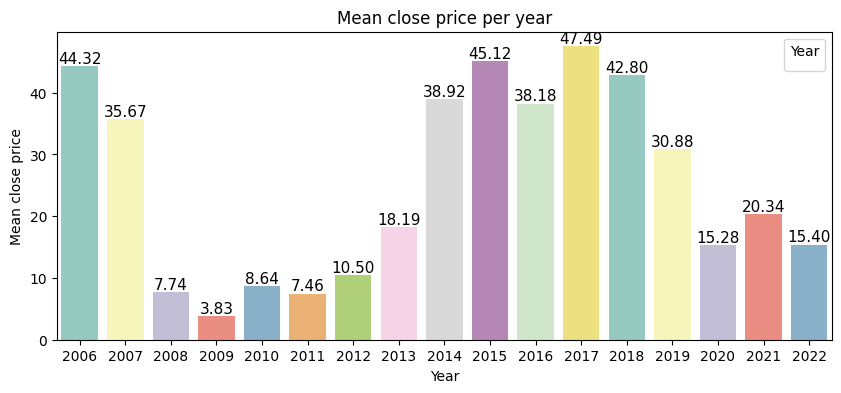

In [28]:
first_years = yearly_mean["Year"].tolist()

# plot the mean close price per month
ax = sns.barplot(data=yearly_mean, x="Year", y="Close", palette="Set3")

plt.title("Mean close price per year")
plt.xlabel("Year")
plt.ylabel("Mean close price")

plt.xticks(range(0,len(first_years)), labels = first_years)
plt.legend(title="Year")

for bar in ax.containers:
    ax.bar_label(bar, fontsize=11, fmt="%.2f")

plt.show()


**Figure**: year 2009 have the lowest close price, year 2017 have the highest close price.

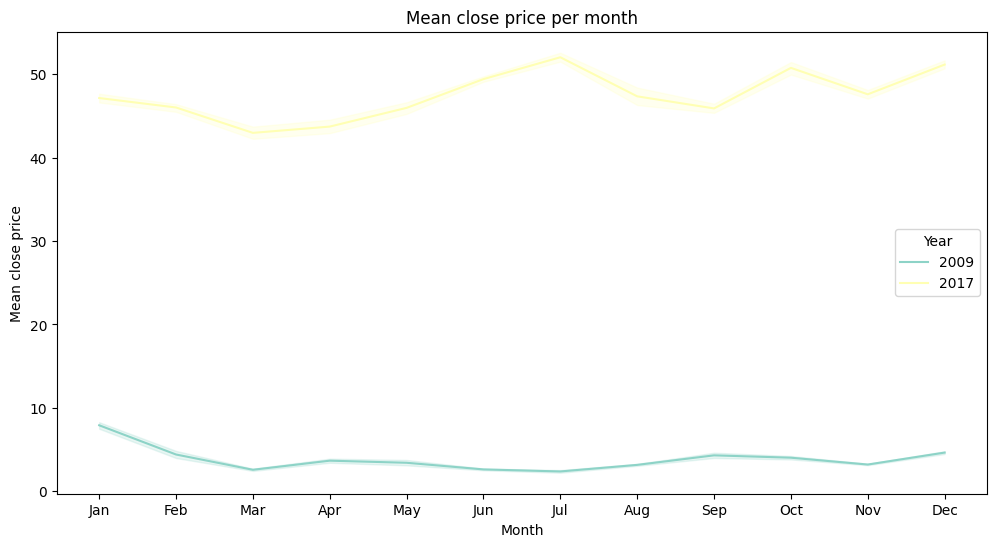

In [29]:
# use lineplot to illustrate both 2009,2017 to examinate
plt.figure(figsize=(12,6))

filtered_df = df[df["Year"].isin([2009,2017])]
sns.lineplot(data=filtered_df, x="Month",y="Close",hue="Year", palette="Set3" )

plt.title("Mean close price per month")
plt.xlabel("Month")
plt.ylabel("Mean close price")

plt.xticks(range(1,13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year")
plt.show()



**Figure**: chart showing the mean close price per years(2009,2017)

We know that capture information from the previous seasonal cycle can help us forecast our time series. Therefore, it is important to determine ways to identify seasonality in time series. Usually, plotting the time series data is enough to observe periodic patterns.

We can plot our target to see if we can visually detect any seasonality.

**Yearly Seasonality**

Yearly cyclic behavior refers to a repeating pattern or trend that orrcurs within each year. Without this pattern, suggest that the stock market data does not exhbit consistent fluctuations or variations that occur predictably each ýear. 


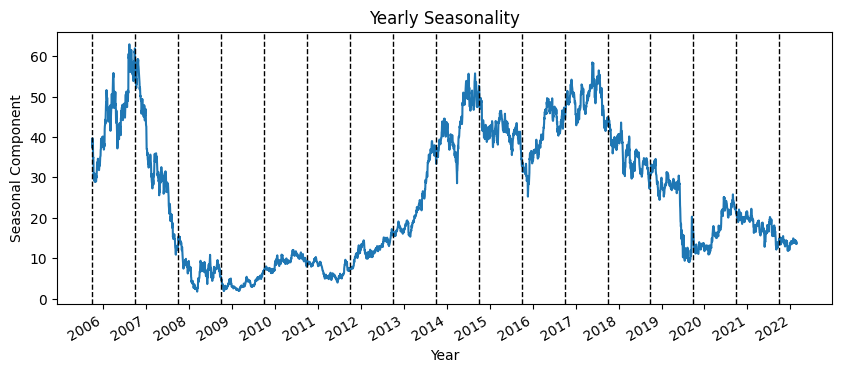

<Figure size 1000x500 with 0 Axes>

In [35]:
fig, ax = plt.subplots()

ax.plot(df["Close"])
for i in np.arange(0, len(df),260):
    ax.axvline(x=i, linestyle="--",color="black",linewidth=1)

plt.title("Yearly Seasonality")
plt.xlabel("Year")
plt.ylabel("Seasonal Component")

plt.xticks(np.arange(67, len(df),260), np.arange(2006,2023,1))
plt.figure(figsize=(10,5))

fig.autofmt_xdate()
plt.tight_layout()


**Figure**: Seasonal pattern in yearly closing price.The dashed vertical line separate periods of 260 working days per year

We can see the yearly closing price doees not show any cyclic behavior. So there is no yearly seasonal pattern. We can identifying seasonal pattern in time series using time series decomposition. We can achive that with tsa.seasonal_decompose function from the statsmodels library 

**Monthly Seasonality**

Monthly cyclic behavior refers to a repeating pattern or trend that occurs within each month. It suggests that there are consistent fluctuations or variations in the stock market data that repeat on a monthly basis. This could be due to various factors, such as economic events, market sentiment, or trading patterns that occur within specific months.